# 1. Introduction

Generally, dimensionality reduction algorithms are used when we want to see the inner properties of the dataset. Sadily, this bunch of algorithms don't consider the label data. But dimensionality reduction algorithms are very helpful when we don't have enough training data and we do have a lot of features to cope with. These algorithms could help us know to which features we need to pay much more attention.

In general, all the dimensionality algorithms could be categorized into two parts, which are projection and maniford learning. The projection method tries to find a lower dimensional hyperplane where the data could be projected and splitted. The most representative example of the projection method is shown below:

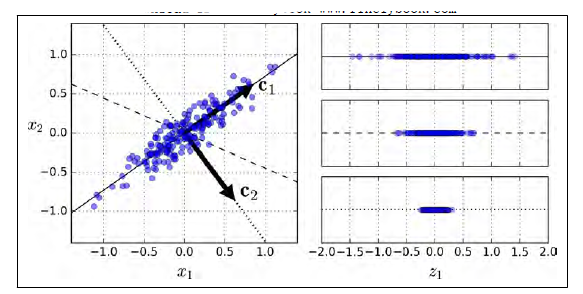

The projection method is always trying to find a hyperplane which could maximize the variance of the dataset. Variance actually means the aount of the information.

However, the project method does not always work. In the following case, we should use the maniford learning algorithm to do the dimensionality reduction.

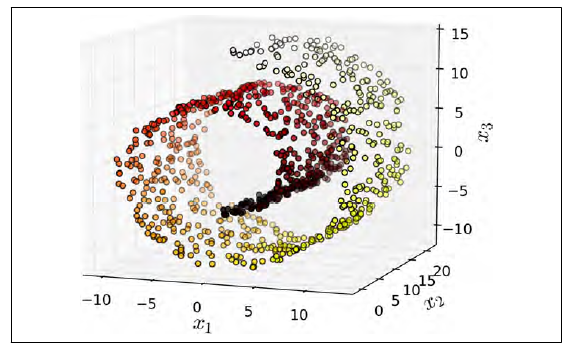

From the figure above, we could see that the projection method won't work. But how could we get the following result?

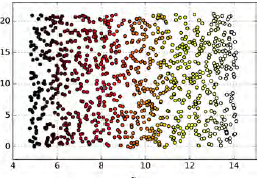

The maniford learning algorithm will help.

In this tutorial, I am going to introduction three most well-known dimensionality algorithms, which are PCA, kernel PCA and LLM.

# 2. Dimensionality Algorithms

## 2.1 PCA

### 2.1.1 Implement the PCA from Scratch

In Python, we could implement PCA generally by numpy or sklearn. In numpy, the **np.linalg.svd** could help us do the PCA decomposition. But don't forget to center the data first. The following code shows how to do the PCA using numpy:

```Python
X_centered = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[:, 0]
c2 = V.T[:, 1]
```

To project the training set onto the hyperplance, you can simply compute the dot product of the training set matrix by the matrix $W_d$, which is defined by the first d columns of the matrix V. The following Python codes show this process:

```Python
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)
```

### 2.1.2 Implement the PCA Using Scikit-learn

But sklearn have provided us with more high-level functions to run this method.

```Python
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
```

Moreover, the attribute **explained_variable_ratio_** indicates the proportion of the dataset's variance that lies along the axis of each principle component. The following code shows how we work out these explained ratios:

```Python
print(pca.explained_variance_ratio_)
```

#### Choose the number of dimensions

To choose the right number of dimensions, we want the interpretation of the variance to be higher than, for instance, 95% of the total information, unless you are reducing the dimensionality for visulization, when you choose the number of dimensions to be 2 or 3. The following code shows the minimum number of dimensions required to preserve 95% of the training set's variance:

```Python
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
```
Then you could set the number of dimensions to be d and run the PCA algorithm again. But a better approach is to specify the percentage in the n_components argument:

```Python
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
```
Another approach is to use the matplotlib to plot the cumsum against the number of dimensions.

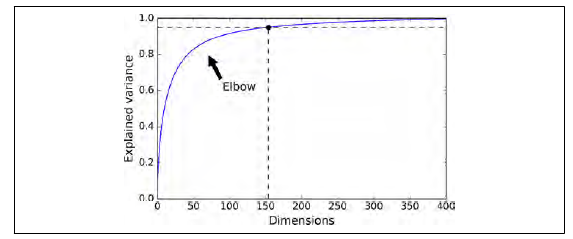

You could also use the inverse_transform function to decompress the compressed data. Even though there is small amount of information loss in this process, the data after compression and decompression is quite similar to the original data(This is true only when you choose the right number of dimensions in the compress session).

```Python
pca = PCA(n_components = 154)
X_mnist_reduced = pca.fit_transform(X_mnist)
X_mnist_recovered = pca.inverse_transform(X_mnist_reduced)
```

#### Other versions of PCA: 1. The Incremental PCA

However, one problem with PCA is that it requires the whole training set to fit in memory in order for the SVD algorithm to run. Fortunately, another version of PCA called **Incremental PCA(IPCA)** algorithm could split the training set into mini-batches and feed this small batch to the IPCA. This is useful for the large training sets, and also to apply the PCA online. In sklearn, we could use the IncrementalPCA to finish this task. Remember to use the partial_fit function to do the PCA for each mini batch.

```Python
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_mnist, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_mnist_reduced = inc_pca.transform(X_mnist)
```

#### Other versions of PCA: 2. The Randomized PCA

This is a stochastic algorithm that quickly finds an approximation of the first d principal components. Its computational complexity is $O(m × d^2) + O(d^3)$, instead of $O(m × n^2) + O(n^3)$, so it is dramatically faster than the previous algorithms when d is much smaller than n.

```Python
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_mnist)
```

## 2.2 Kernel PCA

The kernel PCA is based on the kernel trick. A great video which talks about this trick is given in this link: [kernel trick](https://www.youtube.com/watch?v=H_I0pYdzBSk)

Kernel trick is a mathematical technique that implicitly maps instances into a very high-dimensional space. Why we use kernels? Because a linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space. 

Well, it turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. The following codes show us how to implement Kernel PCA in scikit-learn.

```Python
from sklearn.decomposition import kernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)
```
The hyperparameter gamma is used to configure the sensitivity to differences in feature vectors, which is based on the following equation:

\begin{equation}
K(u,v) = exp(-\gamma ||u-v||^2)
\end{equation}

One thing we need to remember is that the Kernel PCA using the linear kernel is the same as the PCA.

### 2.2.1 Tune the Hyperparameters

However, the Kernel PCA method does introduce a lot of hyperparameters. We could use the simple GridSearch method in sklearn to tune these hyperparameters. The following code shows how to select the best combination of gamma and kernel function.

```Python
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
("kpca", KernelPCA(n_components=2)),
("log_reg", LogisticRegression())
])

param_grid = [{
"kpca__gamma": np.linspace(0.03, 0.05, 10),
"kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3) # cv = 3 means to use 3-fold cross validation
grid_search.fit(X, y)
```

Then the best kernel and the hyperparameter could be worked out by the following:

```Python
print(grid_search.best_params_)
```

**Another way** of thinking this problem is to select the kernel and hyperparameters that **yield the lowest reconstruction error**. You could do this by indicating **fit_inverse_transform = True** as shown in the following code:

```Python
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)
```
By default, fit_inverse_transform=False and KernelPCA has no inverse_transform() method. This method only gets created when you set fit_inverse_transform=True.

Then the reconstruction pre-image error is:

```Python
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)
```

Now you could use the grid search to find the best hyperparameters.

## 2.3 Locally Linear Embedding (LLE)

LLE is a manifold learning algorithm that **does not rely on projections** like the previous algorithms. The following codes show how to implement this algorithm in scikit-learn.

```Python
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10)
X_reduced = lle.fit_transform(X)
```

There are generally two assumptions on the LLE method:

1. The manifold should be continuous
2. LLE fails on the noisy data

In [28]:
import numpy as np

import sklearn
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.manifold import LocallyLinearEmbedding

from matplotlib import pyplot as plt